<a href="https://colab.research.google.com/github/SaxMan96/DeepLearningMaster20192020/blob/master/Assignment%203.%20Facial%20Point%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Assignment 3
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using various deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

Data can be downloaded from https://www.kaggle.com/c/facial-keypoints-detection/data

In the following lines we provide a simple solution: a neural net with a single hidden layer. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by extending the baseline model to convolutional neural nets.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout or BatchNorm.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
    
For developing puposes it is not a bad idea to work with 43x43 images...
    
Advanced suggestions:
+ Use several loss functions (f.e. one computing the MSE of predicted points and another measuring a global deformation of the constellation of points).
+ Can we work in a lower dimensional space for representing points? This could help with hidden points, global deformations, etc.
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [0]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

In [0]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(fname)
    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols) + ['Image']]
        
    print(df.count()) 
    df = df.dropna() 
    
    X = np.vstack(df['Image'].values) / 255. 
    X = X.astype(np.float32) 
    
    if not test: 
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48
        X, y = shuffle(X, y, random_state=42) 
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y

def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols)
    X = X.reshape(-1, 96, 96, 1) 
    
    return X, y

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from fastai.vision import *
from fastai import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import shutil
import torch

rn_seed=1
np.random.seed(rn_seed)
# Any results you write to the current directory are saved as output.
train_path = Path('/train')
test_path = Path('/test')
root = Path('drive/My Drive/Google Colab Data/DL_Assignment_3')
id_lookup = pd.read_csv(root/'IdLookupTable.csv')
# try fillna median
# train_csv = pd.read_csv(root/'training/training.csv').dropna(axis=0)
train_csv = pd.read_csv(root/'training.csv')
test_csv = pd.read_csv(root/'test.csv')
for c in train_csv.columns:
    if(train_csv[c].dtype!='object'):
        train_csv[c]=train_csv[c].fillna(train_csv[c].median())

In [0]:
def save_str_img(strimg,w,h,flpath):
    px=255-np.array(strimg.split(),dtype=int)
    if(len(px)==w*h and len(px)%w==0 and len(px)%h==0):
        cpx = list(px.reshape(w,h))
        img = Image(Tensor([cpx,cpx,cpx]))
        img.save(flpath)
        return img
    else:
        raise Exception("Invalid height and width")

In [0]:
# make image folders
# shutil.rmtree(train_path)
train_path.mkdir(exist_ok=True)
test_path.mkdir(exist_ok=True)

In [0]:
# # for each row
# for index, train_row in train_csv.iterrows():
#     save_str_img(train_row.Image,96,96,train_path/(str(index)+'.jpg'))

In [0]:
# for each row
for index, test_row in test_csv.iterrows():
    save_str_img(test_row.Image,96,96,test_path/(str(index)+'.jpg'))
    print(index)

In [0]:
def get_locs(flname):
    index = int(flname.name[:-4])
    plist=[]
    coords=list(train_csv.loc[index])
    for i in range(len(coords)//2):
        plist.append([coords[i*2+1],coords[i*2]])
    return tensor(plist)
#     return tensor([coords[1],coords[0]])

In [0]:
# make points image data bunch
# TODO remove transforms
data = (PointsItemList.from_folder(train_path)
        .split_by_rand_pct(0.05,seed=rn_seed)
        .label_from_func(get_locs)
        .transform([],size=(96,96))
        .databunch(num_workers=0)
       )

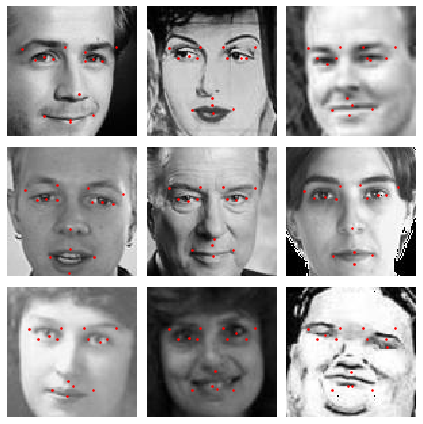

In [43]:
data.show_batch(3,figsize=(6,6))

In [0]:
# calculates distance between true and predictions
def mloss(y_true, y_pred):
    y_true=y_true.view(-1,15,2)
    
    y_true[:,:,0]=y_true[:,:,0].clone()-y_pred[:,:,0]
    y_true[:,:,1]=y_true[:,:,1].clone()-y_pred[:,:,1]
    
    y_true[:,:,0]=y_true[:,:,0].clone()**2
    y_true[:,:,1]=y_true[:,:,1].clone()**2
    
    return y_true.sum(dim=2).sum(dim=1).sum()

In [45]:
learn = cnn_learner(data,models.resnet152,loss_func=mloss)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 92.7MB/s]


In [46]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,5166.668945,1010.902710,00:33
1,2070.596436,155.418640,00:32
2,501.523041,26.733259,00:31
3,98.285767,8.865452,00:31
4,25.567966,7.501570,00:31
5,14.308755,8.494958,00:31
6,11.032684,6.549444,00:31
7,8.901883,5.721399,00:31
8,7.051696,5.269122,00:31
9,6.333422,5.146420,00:31


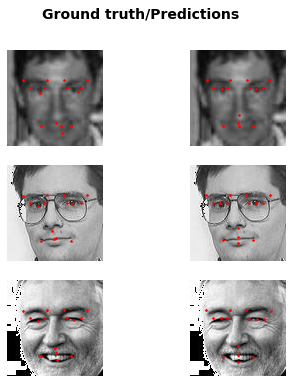

In [47]:
learn.show_results(rows=3,figsize=(6,6))

In [0]:
learn.save('s1')

In [0]:
learn.load('s1');

In [0]:
learn.unfreeze()

In [51]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


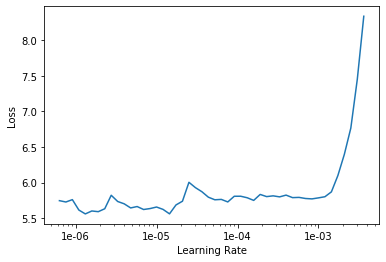

In [52]:
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(30,5e-5)

epoch,train_loss,valid_loss,time
0,6.061208,5.009837,00:44
1,5.825180,4.840979,00:44
2,5.461418,4.594625,00:44
3,5.104240,4.284182,00:44
4,4.433844,3.716169,00:44
5,3.898898,3.345419,00:44
6,3.427822,2.974795,00:44
7,3.125570,2.928364,00:44
8,2.767224,2.814640,00:44
9,2.368941,2.415714,00:44


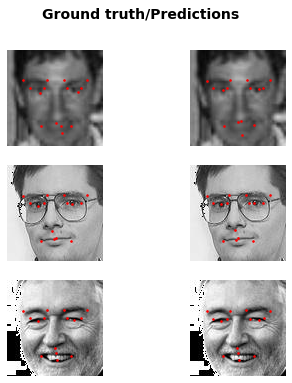

In [54]:
learn.show_results(rows=3,figsize=(6,6))

In [0]:
def flp(npa):
    for i in range(npa.shape[0]):
        if(i%2==1):
            tmp=npa[i]
            npa[i]=npa[i-1]
            npa[i-1]=tmp
    return npa

In [0]:
def get_coords(imgpnts):
    return ((imgpnts+1)*48).numpy()

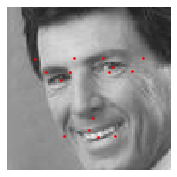

In [57]:
test_img = open_image(test_path/'1600.jpg')
pred = learn.predict(test_img)
test_img.show(y=pred[0])

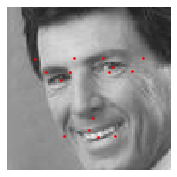

In [58]:
test_img = open_image(test_path/'1600.jpg')
pred = learn.predict(test_img)
test_img.show(y=ImagePoints(FlowField(test_img.size,torch.from_numpy(get_coords(pred[1])))))

In [0]:
a=list(train_csv.columns.values)
a.remove('Image')
a.append('ImageId')

In [0]:
test_preds = pd.DataFrame(columns=a)

In [61]:
from ipywidgets import IntProgress
from IPython.display import display

f = IntProgress(min=0, max=test_csv.count()[0]) # instantiate the bar
display(f)
for test_index in range(test_csv.count()[0]):
    timg = open_image(test_path/(str(test_index)+'.jpg'))
    pred = learn.predict(timg)
    a=np.abs(flp(get_coords(pred[1]).reshape(1,-1)[0]))
    a=np.append(a,test_csv.loc[test_index].ImageId)
    test_preds.loc[test_index]=a
    f.value+=1

IntProgress(value=0, max=1783)

In [0]:
test_preds.ImageId=test_preds.ImageId.astype('int')

In [0]:
sub = pd.DataFrame(columns=['RowId','Location'])
for index,row in id_lookup.iterrows():
    fname = row.FeatureName
    trow=test_preds.loc[test_preds['ImageId']==row.ImageId]
    sub.loc[index]=[row.RowId,trow.iloc[0][fname]]

In [64]:
sub.RowId=sub.RowId.astype('int')
sub.head()

,RowId,Location
0,1,65.942947
1,2,37.150726
2,3,28.924717
3,4,35.801018
4,5,59.942162


In [0]:
sub.to_csv("sub.csv",index=False)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(9216,)))
model.add(Dense(30)) 

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd) 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [0]:
X, y = load()

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

batch_size = 32
epochs = 100

history = model.fit(X, y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2 
                   )

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

Epoch 67/100
1712/1712 [==============================] - 1s 509us/step - loss: 0.0027 - val_loss: 0.0040
Epoch 68/100
1712/1712 [==============================] - 1s 507us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 69/100
1712/1712 [==============================] - 1s 569us/step - loss: 0.0027 - val_loss: 0.0043
Epoch 70/100
1712/1712 [==============================] - 1s 520us/step - loss: 0.0027 - val_loss: 0.0041
Epoch 71/100
1712/1712 [==============================] - 1s 419us/step - loss: 0.0027 - val_loss: 0.0038
Epoch 72/100
1712/1712 [==============================] - 1s 412us/step - loss: 0.0026 - val_loss: 0.0036
Epoch 73/100
1712/1712 [==============================] - 1s 464us/step - loss: 0.0026 - val_loss: 0.0038
Epoch 74/100
1712/1712 [==============================] - 1s 458us/step - loss: 0.0026 - val_loss: 0.0037
Epoch 75/100
1712/1712 [==============================] - 1s 540us/step - loss: 0.0026 - val_loss: 0.0036
Epoch 76/100
1712/1712 [======================

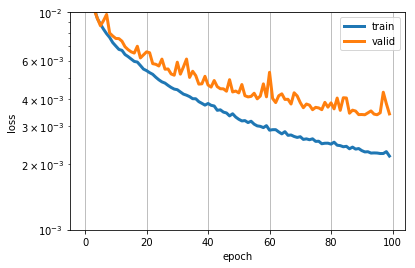

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, linewidth=3, label='train')
plt.plot(val_loss, linewidth=3, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(1e-3, 1e-2)
plt.yscale('log') 
plt.show()

In [0]:
X_test, _ = load(test=True) 
y_pred = model.predict(X_test) 

def plot_sample(x, y, axis):
    img = x.reshape(96, 96) 
    axis.imshow(img, cmap='gray') 

    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

ImageId    1783
Image      1783
dtype: int64


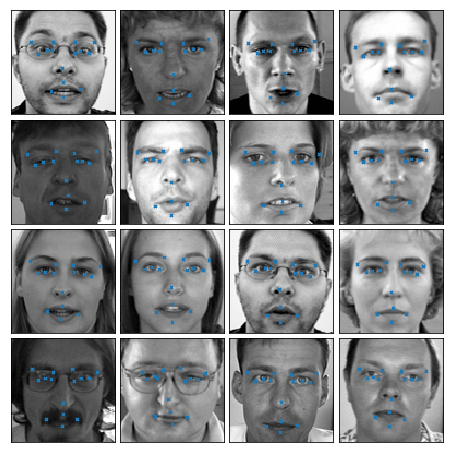

In [0]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)

plt.show()